**21st International Conference on Business Process Management**

Forum for researchers and practitioners in the field of Business Process Management.

Below the descriptive statistics is presented. 

In [139]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import display

import networkx as nxt
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

import PyPDF2
import re

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np


In [140]:
data = pd.read_excel("bpm_overview.xlsx")

Total amount of published papers: 76


Number of authors: 202
Average Authors per Paper: 3.42
Amount of scientific papers by categories:
paper            27
forum paper      23
demo             16
Ph.D. project     7
disseration       3


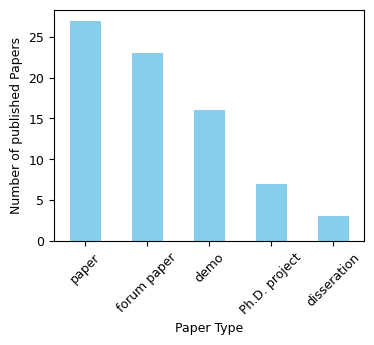

In [141]:
#total number of papers presented at the conference
total_papers = data['Paper_Title'].nunique()
print(f"Total amount of published papers: {total_papers}\n")

#Total number of authors 
unique_authors_num = data.groupby(['First_Name', 'Last_Name']).ngroup().nunique()
print(f"\nNumber of authors: {unique_authors_num}")

#the average number of authors per paper
paper_author_counts = data['Paper_Title'].value_counts()
average_authors_per_paper = paper_author_counts.mean()
print(f'Average Authors per Paper: {average_authors_per_paper:.2f}')

#amount of papers by category
data_byCat = data.groupby('Paper_Type')['Paper_Title'].nunique()
data_byCat = data_byCat.sort_values(ascending=False)
print(f"Amount of scientific papers by categories:\n{data_byCat.to_string(header=False)}")

#amount of papers by category - visualization
plt.figure(figsize=(4, 3))
data_byCat.plot(kind='bar', color='skyblue')
plt.xlabel('Paper Type')
plt.ylabel('Number of published Papers')
plt.xticks(rotation=45)
plt.show()

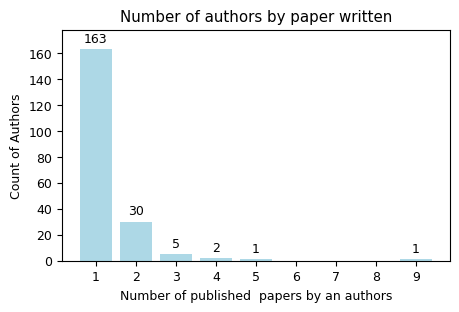

In [142]:
data_byAuthor = data.groupby(['First_Name', 'Last_Name'])['Paper_Title'].nunique()
data_byAuthor = data_byAuthor.reset_index()  

# Number of authors by paper written
paper_count_by_author = data_byAuthor.groupby('Paper_Title').size().reset_index(name='Count')


plt.figure(figsize=(5, 3))
bars = plt.bar(paper_count_by_author['Paper_Title'], paper_count_by_author['Count'], color='lightblue')
plt.title('Number of authors by paper written')
plt.xlabel('Number of published  papers by an authors')
plt.ylabel('Count of Authors')
plt.xticks(rotation=0)
plt.ylim(0, max(paper_count_by_author['Count']) + 15) 
plt.rcParams.update({'font.size': 9})
plt.xticks(range(1, 10))


for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  
                 textcoords='offset points',
                 ha='center', va='bottom',  fontsize=9)

plt.show()

First_Name      Last_Name    
Wil M.P.        van der Aalst    9
Stefanie        Rinderle-Ma      5
Jan             Mendling         4
Marco           Montali          4
Remco           Dijkman          3
Pnina           Soffer           3
Timotheus       Kampik           3
Sebastiaan      van Zelst        3
Fabrizio Maria  Maggi            3
Name: Paper_Title, dtype: int64


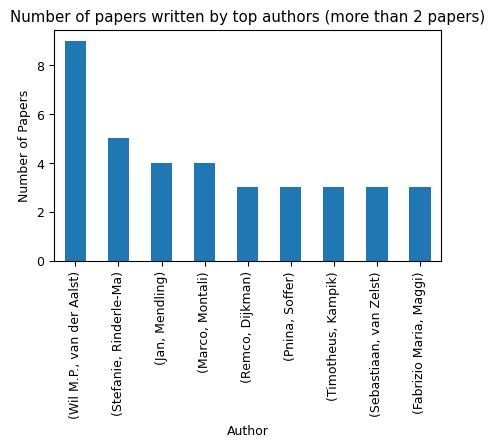

In [143]:
#"key players"
data_byAuthor = data.groupby(['First_Name', 'Last_Name'])['Paper_Title'].nunique()
data_byAuthor = data_byAuthor.sort_values(ascending=False)
top_authors = data_byAuthor[data_byAuthor > 2]

print(top_authors)

plt.figure(figsize=(5, 3))
top_authors.plot(kind='bar')
plt.title('Number of papers written by top authors (more than 2 papers)')
plt.xlabel('Author')
plt.ylabel('Number of Papers')
plt.xticks(rotation=90)
plt.show()

Keep only high profile papers: BPM Forum and Main Track

In [144]:
#analyze universities - bring to the wide format
data[['org1', 'org2', 'org3']] = data['University'].str.split(';', expand=True)
data[['ctry1', 'ctry2', 'ctry3']] = data['Country'].str.split(';', expand=True)

#remove leading and trailing whitespaces
data_wide = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


In [145]:
#data cleaning
def unify_org_name(value):
    if value is None:
        return None 
    
    replacements = {
        'RWTH': 'RWTH Aachen University',
        'Hasso': 'Hasso Plattner Institute',
        'Weizenbaum': 'Weizenbaum Institute',
        'Technion': 'Technion - Israel Institute of Technology',
        'WU Vienna': 'Vienna University of Economics and Business',
        'Wirtschaftsuniversität Wien': 'Vienna University of Economics and Business',
        'Sapienza': 'Sapienza University of Rome',
        'Fraunhofer Institute for Applied Information Technology FIT': 'Fraunhofer FIT',
        'Branch Business & Information Systems Engineering of the Fraunhofer FIT': 'Fraunhofer FIT'
    }
    
    for key, replacement in replacements.items():
        if key in value:
            return replacement
    
    return value


data['org1'] = data['org1'].apply(unify_org_name)
data['org2'] = data['org2'].apply(unify_org_name)
data['org3'] = data['org3'].apply(unify_org_name)


In [146]:
papers_countries = data_wide.groupby('Paper_Title')['Country'].apply(lambda x: ', '.join(set(x.str.split(', ').sum()))).reset_index()

#replace all ; to , - some bag, does not work without it 
papers_countries['Country'] = papers_countries['Country'].str.replace(';', ',')

#remove duplicates
papers_countries['Country'] = papers_countries['Country'].str.split(', ').apply(lambda x: ', '.join(set(x)))


country_counts = papers_countries['Country'].str.split(', ').explode().value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

print('An analysis to determine the countries of affiliation of the authors and summary of the number of authors from each country who published at the conference:')
display(country_counts)

def are_countries_same(country_string):
    countries = country_string.split(', ')
    return 'YES' if not all(country == countries[0] for country in countries) else 'NO'


#check if international cooperation was present(e.g. if authors are from different countries)
papers_countries['International'] = papers_countries['Country'].apply(are_countries_same)

# Count the occurrences of 'YES' and 'NO' in the 'International' column
international_counts = papers_countries['International'].value_counts()

percentage_yes = (international_counts.get('YES', 0) / len(papers_countries)) * 100

# Print the result
print(f"International cooperation was present during writing of {percentage_yes:.2f}% of papers")
#papers_countries['International'] = papers_countries['Country_List'].apply(check_international)
display(papers_countries)


An analysis to determine the countries of affiliation of the authors and summary of the number of authors from each country who published at the conference:


,Country,Count
0,Germany,40
1,The Netherlands,14
2,Italy,12
3,Austria,6
4,Australia,6
5,Spain,6
6,Denmark,5
7,Israel,4
8,Chile,3
9,Belgium,3


International cooperation was present during writing of 42.11% of papers


,Paper_Title,Country,International
0,A Collection of Simulated Event Logs for Fairn...,Germany,NO
1,A Novel Multi-Perspective Trace Clustering Tec...,Belgium,NO
2,A Reference Data Model to Specify Event Logs f...,"Norway, Spain, Italy",YES
3,A Tool for Visualizing Costs of Process Varian...,Chile,NO
4,Action-Evolution Petri Nets: a Framework for M...,The Netherlands,NO
...,...,...,...
71,Towards a Theory on Process Automation Effects,"Germany, Austria",YES
72,Trusted Compliance Checking on Blockchain with...,"Italy, Denmark",YES
73,Verifying Resource Compliance Requirements Fro...,"The Netherlands, Germany",YES
74,Workarounds: The Path from Detection to Improv...,The Netherlands,NO


Visual representation - interactive map, where is shown from which researchers are researchers who published papers for the conference. (For blog-post I will zoom in and make a screenshots)

In [147]:
df = pd.read_excel("coordinates.xlsx", sheet_name='countries')
coordinates = df[df['name'].isin(country_counts['Country'])]
countries = coordinates.merge(country_counts, left_on='name', right_on='Country', how='left')
countries = countries.sort_values(ascending=False, by='Count')
countries = countries.drop('name', axis=1)
display(countries)

countries['text'] = countries['Country'] +': '+ countries['Count'].astype(str) +' researchers'
limits = [(0,1),(2,6),(7,11), (12,18)]
colors = ["royalblue","orange","lightseagreen","crimson","lightgrey"]
cities = []
scale = 10

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = countries[lim[0]:lim[1]+1]
    min_count = df_sub['Count'].min()
    max_count = df_sub['Count'].max()
    label = f'{min_count} - {max_count}'

    fig.add_trace(go.Scattergeo(
        locationmode='ISO-3',
        lon=df_sub['longitude'],
        lat=df_sub['latitude'],
        text=df_sub['text'],
        marker=dict(
            size=df_sub['Count'] * scale,
            color=colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode='area'
        ),
        name=label
    ))


fig.update_layout(
        title_text = 'BPM Conference 2023 - number of researches in different countries',
        showlegend = True,
        geo = dict(
            showcountries = True,
            resolution = 50,
            projection_type = 'winkel tripel',
            scope = 'world',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

,country,latitude,longitude,Country,Count
7,DE,51.165691,10.451526,Germany,40
13,IT,41.871940,12.567380,Italy,12
0,AT,47.516231,14.550072,Austria,6
1,AU,-25.274398,133.775136,Australia,6
10,ES,40.463667,-3.749220,Spain,6
8,DK,56.263920,9.501785,Denmark,5
12,IL,31.046051,34.851612,Israel,4
2,BE,50.503887,4.469936,Belgium,3
5,CL,-35.675147,-71.542969,Chile,3
9,EE,58.595272,25.013607,Estonia,2


In [148]:
data['org1'] = data['org1'].str.strip()
data['org2'] = data['org2'].str.strip()
data['org3'] = data['org3'].str.strip()

data['Organizations'] = data[['org1', 'org2', 'org3']].apply(lambda x: ', '.join(x.dropna()), axis=1)

# Group the data by 'Paper Title' and extract distinct universities
uni = data.groupby('Paper_Title')['Organizations'].apply(lambda x: ', '.join(set(x.str.split(', ').sum()))).reset_index()
uni_comp = uni
uni.to_excel('organization.xlsx', index=False)
# Print the result


uni['Organizations'] = uni['Organizations'].str.split(', ').apply(lambda x: ', '.join(set(x)))

# Count the occurrences of each organization
organization_counts = uni['Organizations'].str.split(', ').explode().value_counts().reset_index()
organization_counts.columns = ['Organization', 'Count']
total_orgs = organization_counts.shape[0]

# Print the result
print(f"Total number of universities and other organisations involved: {total_orgs}")
display(organization_counts)


def are_orgs_same(org_string):
    orgs = org_string.split(', ')
    return 'NO' if len(set(orgs)) == 1 else 'YES'


# Apply the function to each row and create the 'All_Same' column
uni['Interuniversity'] = uni['Organizations'].apply(are_orgs_same)

interuni_counts = uni['Interuniversity'].value_counts()


interuni = (interuni_counts.get('YES', 0) / len(uni)) * 100

# Print the result
print(f"Cooperation between different universities or organizations was present during the creating of {interuni:.2f}% projects")


Total number of universities and other organisations involved: 83


,Organization,Count
0,RWTH Aachen University,12
1,Technical University of Munich,8
2,Eindhoven University of Technology,8
3,Free University of Bozen-Bolzano,5
4,Fraunhofer FIT,5
...,...,...
78,University of Copenhagen,1
79,University of Castilla - La Mancha,1
80,University of Udine,1
81,University of Naples Federico II,1


Cooperation between different universities or organizations was present during the creating of 63.16% projects


**Landscape of how the community is interconnected.**

Pink nodes represent universities(other organizations) which are connected with more than 5 other universities(organizations) through the creating scientific projects for the conference. Blue: 2 to 5 connections and Green: 1

,Paper_Title,Organizations,Interuniversity
0,A Collection of Simulated Event Logs for Fairn...,RWTH Aachen University,NO
1,A Novel Multi-Perspective Trace Clustering Tec...,KU Leuven,NO
2,A Reference Data Model to Specify Event Logs f...,"Oslo Metropolitan University, SINTEF AS, Sapie...",YES
3,A Tool for Visualizing Costs of Process Varian...,Pontificia Universidad Católica de Chile,NO
4,Action-Evolution Petri Nets: a Framework for M...,"Eindhoven University of Technology, Eindhoven ...",YES
...,...,...,...
71,Towards a Theory on Process Automation Effects,"Humboldt-Universität zu Berlin, Kühne Logistic...",YES
72,Trusted Compliance Checking on Blockchain with...,"Technical University of Denmark, Politecnico d...",YES
73,Verifying Resource Compliance Requirements Fro...,"Eindhoven University of Technology, Technical ...",YES
74,Workarounds: The Path from Detection to Improv...,Utrecht University,NO


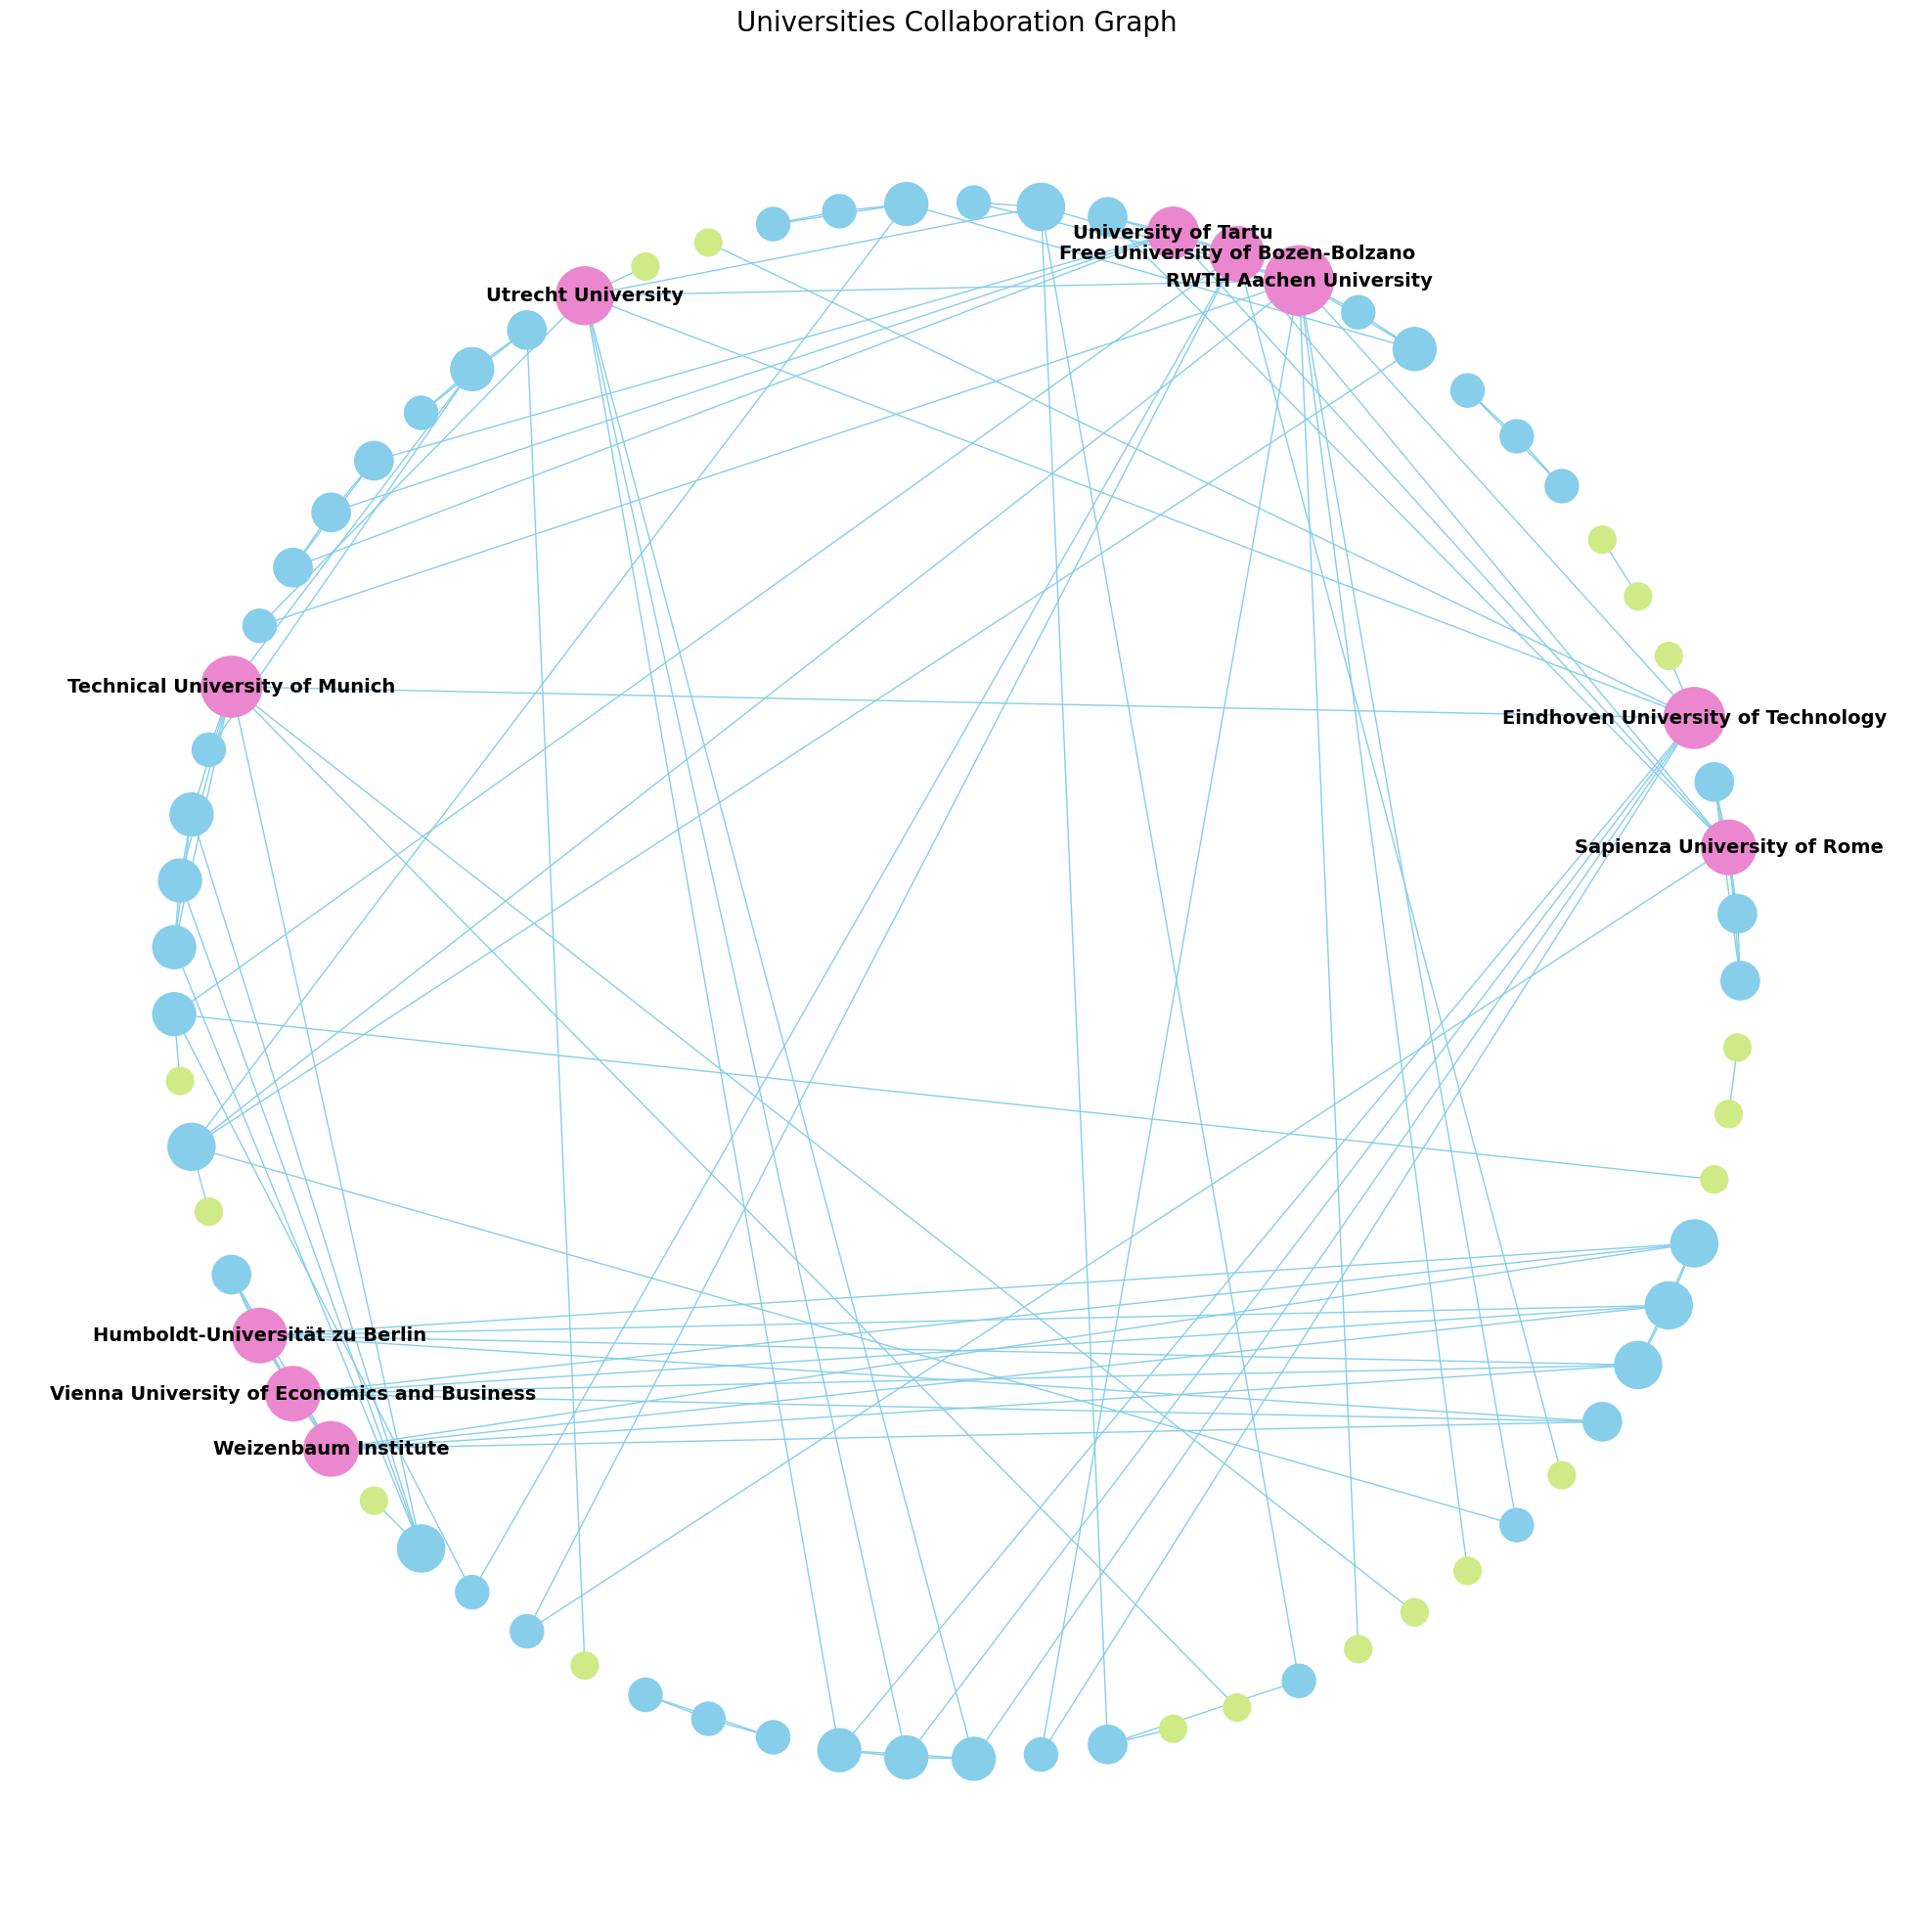

In [149]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


uni = uni_comp
display(uni)
uni['Organizations'] = uni['Organizations'].str.split(', ')
G = nx.Graph()

for index, row in uni.iterrows():
    universities = row['Organizations']
    if universities is not None:
        # Add edges to the graph for all pairs of universities
        for u1 in universities:
            for u2 in universities:
                if u1 != u2:
                    if G.has_edge(u1, u2):
                        G[u1][u2]['weight'] += 1
                    else:
                        G.add_edge(u1, u2, weight=1)

# Calculate edge colors based on edge weights (collaboration strength)
# edge_colors = []
# for u, v, data in G.edges(data=True):
#     weight = data['weight']
#     if weight >= 5:
#         edge_colors.append('red')
#     else:
#         edge_colors.append('skyblue')

# node sizes 
node_degrees = dict(G.degree())
node_sizes = [200 * (degree + 1) for degree in node_degrees.values()]  # Increase scaling for larger nodes

#  node colors 
node_colors = ['#87CEEB' if (degree <= 5 and degree >= 2) else ('#CEEB87' if degree < 2 else '#EB87CE') for degree in node_degrees.values()]

plt.figure(figsize=(25, 25))  
pos = nx.circular_layout(G) 
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edge_color='skyblue')
node_labels = {}
for node, degree in node_degrees.items():
    if degree > 5:
        node_labels[node] = node
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=14, font_color='black', font_weight='semibold')
#nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_weight='bold')
plt.title('Universities Collaboration Graph', fontsize=20)
plt.axis('off')
plt.show()


In [150]:
data_filtered = data.query("Paper_Type in ['forum paper', 'paper']")

In [151]:
#amount of unique papers in main track and forum categories
total_papers_hp = data_filtered['Paper_Title'].nunique()
print(f"Unique number of papers in Main Track and Forum categories: {total_papers_hp}")

#authors_count
authors_num_hp = data_filtered.groupby(['First_Name', 'Last_Name']).ngroup().nunique()
print(f"\nNumber of authors: {authors_num_hp}")

#the average number of authors per paper
author_counts_hp = data_filtered['Paper_Title'].value_counts()
av_authors_hp = author_counts_hp.mean()
print(f'Average Authors per Paper: {av_authors_hp:.2f}\n')


# "key players"
data_byAuthor_hp = data_filtered.groupby(['First_Name', 'Last_Name'])['Paper_Title'].nunique()
data_byAuthor_hp = data_byAuthor.sort_values(ascending=False)
top_authors = data_byAuthor[data_byAuthor > 1]

print("\"Key Players\" amoung high profile papers:\n")
print(top_authors)


Unique number of papers in Main Track and Forum categories: 50

Number of authors: 150
Average Authors per Paper: 3.64

"Key Players" amoung high profile papers:

First_Name      Last_Name    
Wil M.P.        van der Aalst    9
Stefanie        Rinderle-Ma      5
Jan             Mendling         4
Marco           Montali          4
Remco           Dijkman          3
Pnina           Soffer           3
Timotheus       Kampik           3
Sebastiaan      van Zelst        3
Fabrizio Maria  Maggi            3
Massimiliano    de Leoni         2
Marco           Pegoraro         2
Jochen          De Weerdt        2
Ralph           Bergmann         2
Barbara         Weber            2
Sebastiaan J.   van Zelst        2
Dirk            Fahland          2
Sarah           Winkler          2
Sander J.J.     Leemans          2
Irit            Hadar            2
Dario           Benvenuti        2
Iris            Beerepoot        2
Tijs            Slaats           2
Fabian          Stiehle          2
Ig

In [152]:
data_wide_filtered = data.query("Paper_Type in ['forum paper', 'paper']")
# data_wide_filtered['org1'] = data_wide_filtered['org1'].str.strip()
# data_wide_filtered['org2'] = data_wide_filtered['org2'].str.strip()
# data_wide_filtered['org3'] = data_wide_filtered['org3'].str.strip()

# data_wide_filtered['Organizations'] = data_wide_filtered[['org1', 'org2', 'org3']].apply(lambda x: ', '.join(x.dropna()), axis=1)

# Group the data by 'Paper Title' and extract distinct universities
uni_filtered = data_wide_filtered.groupby('Paper_Title')['Organizations'].apply(lambda x: ', '.join(set(x.str.split(', ').sum()))).reset_index()
uni_comp_f = uni_filtered
# uni_filtered.to_excel('organization.xlsx', index=False)

#uni_filtered['Organizations'] = uni_filtered['Organizations'].str.split(', ').apply(lambda x: ', '.join(set(x)))

# Count the occurrences of each organization
organization_counts_f = uni_filtered['Organizations'].str.split(', ').explode().value_counts().reset_index()
organization_counts_f.columns = ['Organization', 'Count']

# Print the result
display(organization_counts_f)


def are_orgs_same(org_string):
    orgs = org_string.split(', ')
    return 'NO' if len(set(orgs)) == 1 else 'YES'


# Apply the function to each row and create the 'All_Same' column
uni_filtered['Collaboration'] = uni_filtered['Organizations'].apply(are_orgs_same)
display(uni)

interuni_counts_f = uni_filtered['Collaboration'].value_counts()


interuni = (interuni_counts_f.get('YES', 0) / len(uni_filtered)) * 100

# Print the result
print(f"Cooperation between different universities or organization was present during the creating of {interuni:.2f}% projects")

,Organization,Count
0,RWTH Aachen University,8
1,Eindhoven University of Technology,7
2,Technical University of Munich,5
3,Vienna University of Economics and Business,4
4,Humboldt-Universität zu Berlin,4
...,...,...
63,University of Copenhagen,1
64,University of Castilla - La Mancha,1
65,Eindhoven Artificial Intelligence Systems Inst...,1
66,University of Udine,1


,Paper_Title,Organizations,Interuniversity
0,A Collection of Simulated Event Logs for Fairn...,[RWTH Aachen University],NO
1,A Novel Multi-Perspective Trace Clustering Tec...,[KU Leuven],NO
2,A Reference Data Model to Specify Event Logs f...,"[Oslo Metropolitan University, SINTEF AS, Sapi...",YES
3,A Tool for Visualizing Costs of Process Varian...,[Pontificia Universidad Católica de Chile],NO
4,Action-Evolution Petri Nets: a Framework for M...,"[Eindhoven University of Technology, Eindhoven...",YES
...,...,...,...
71,Towards a Theory on Process Automation Effects,"[Humboldt-Universität zu Berlin, Kühne Logisti...",YES
72,Trusted Compliance Checking on Blockchain with...,"[Technical University of Denmark, Politecnico ...",YES
73,Verifying Resource Compliance Requirements Fro...,"[Eindhoven University of Technology, Technical...",YES
74,Workarounds: The Path from Detection to Improv...,[Utrecht University],NO


Cooperation between different universities or organization was present during the creating of 74.00% projects


**Landscape of how the community is interconnected.High Profile papers ** 

Red nodes represent universities(other organizations) which are connected with more than 5 other universities(organizations) through the creating scientific projects for the conference. Blue: 2 to 5 connections and Green: 1

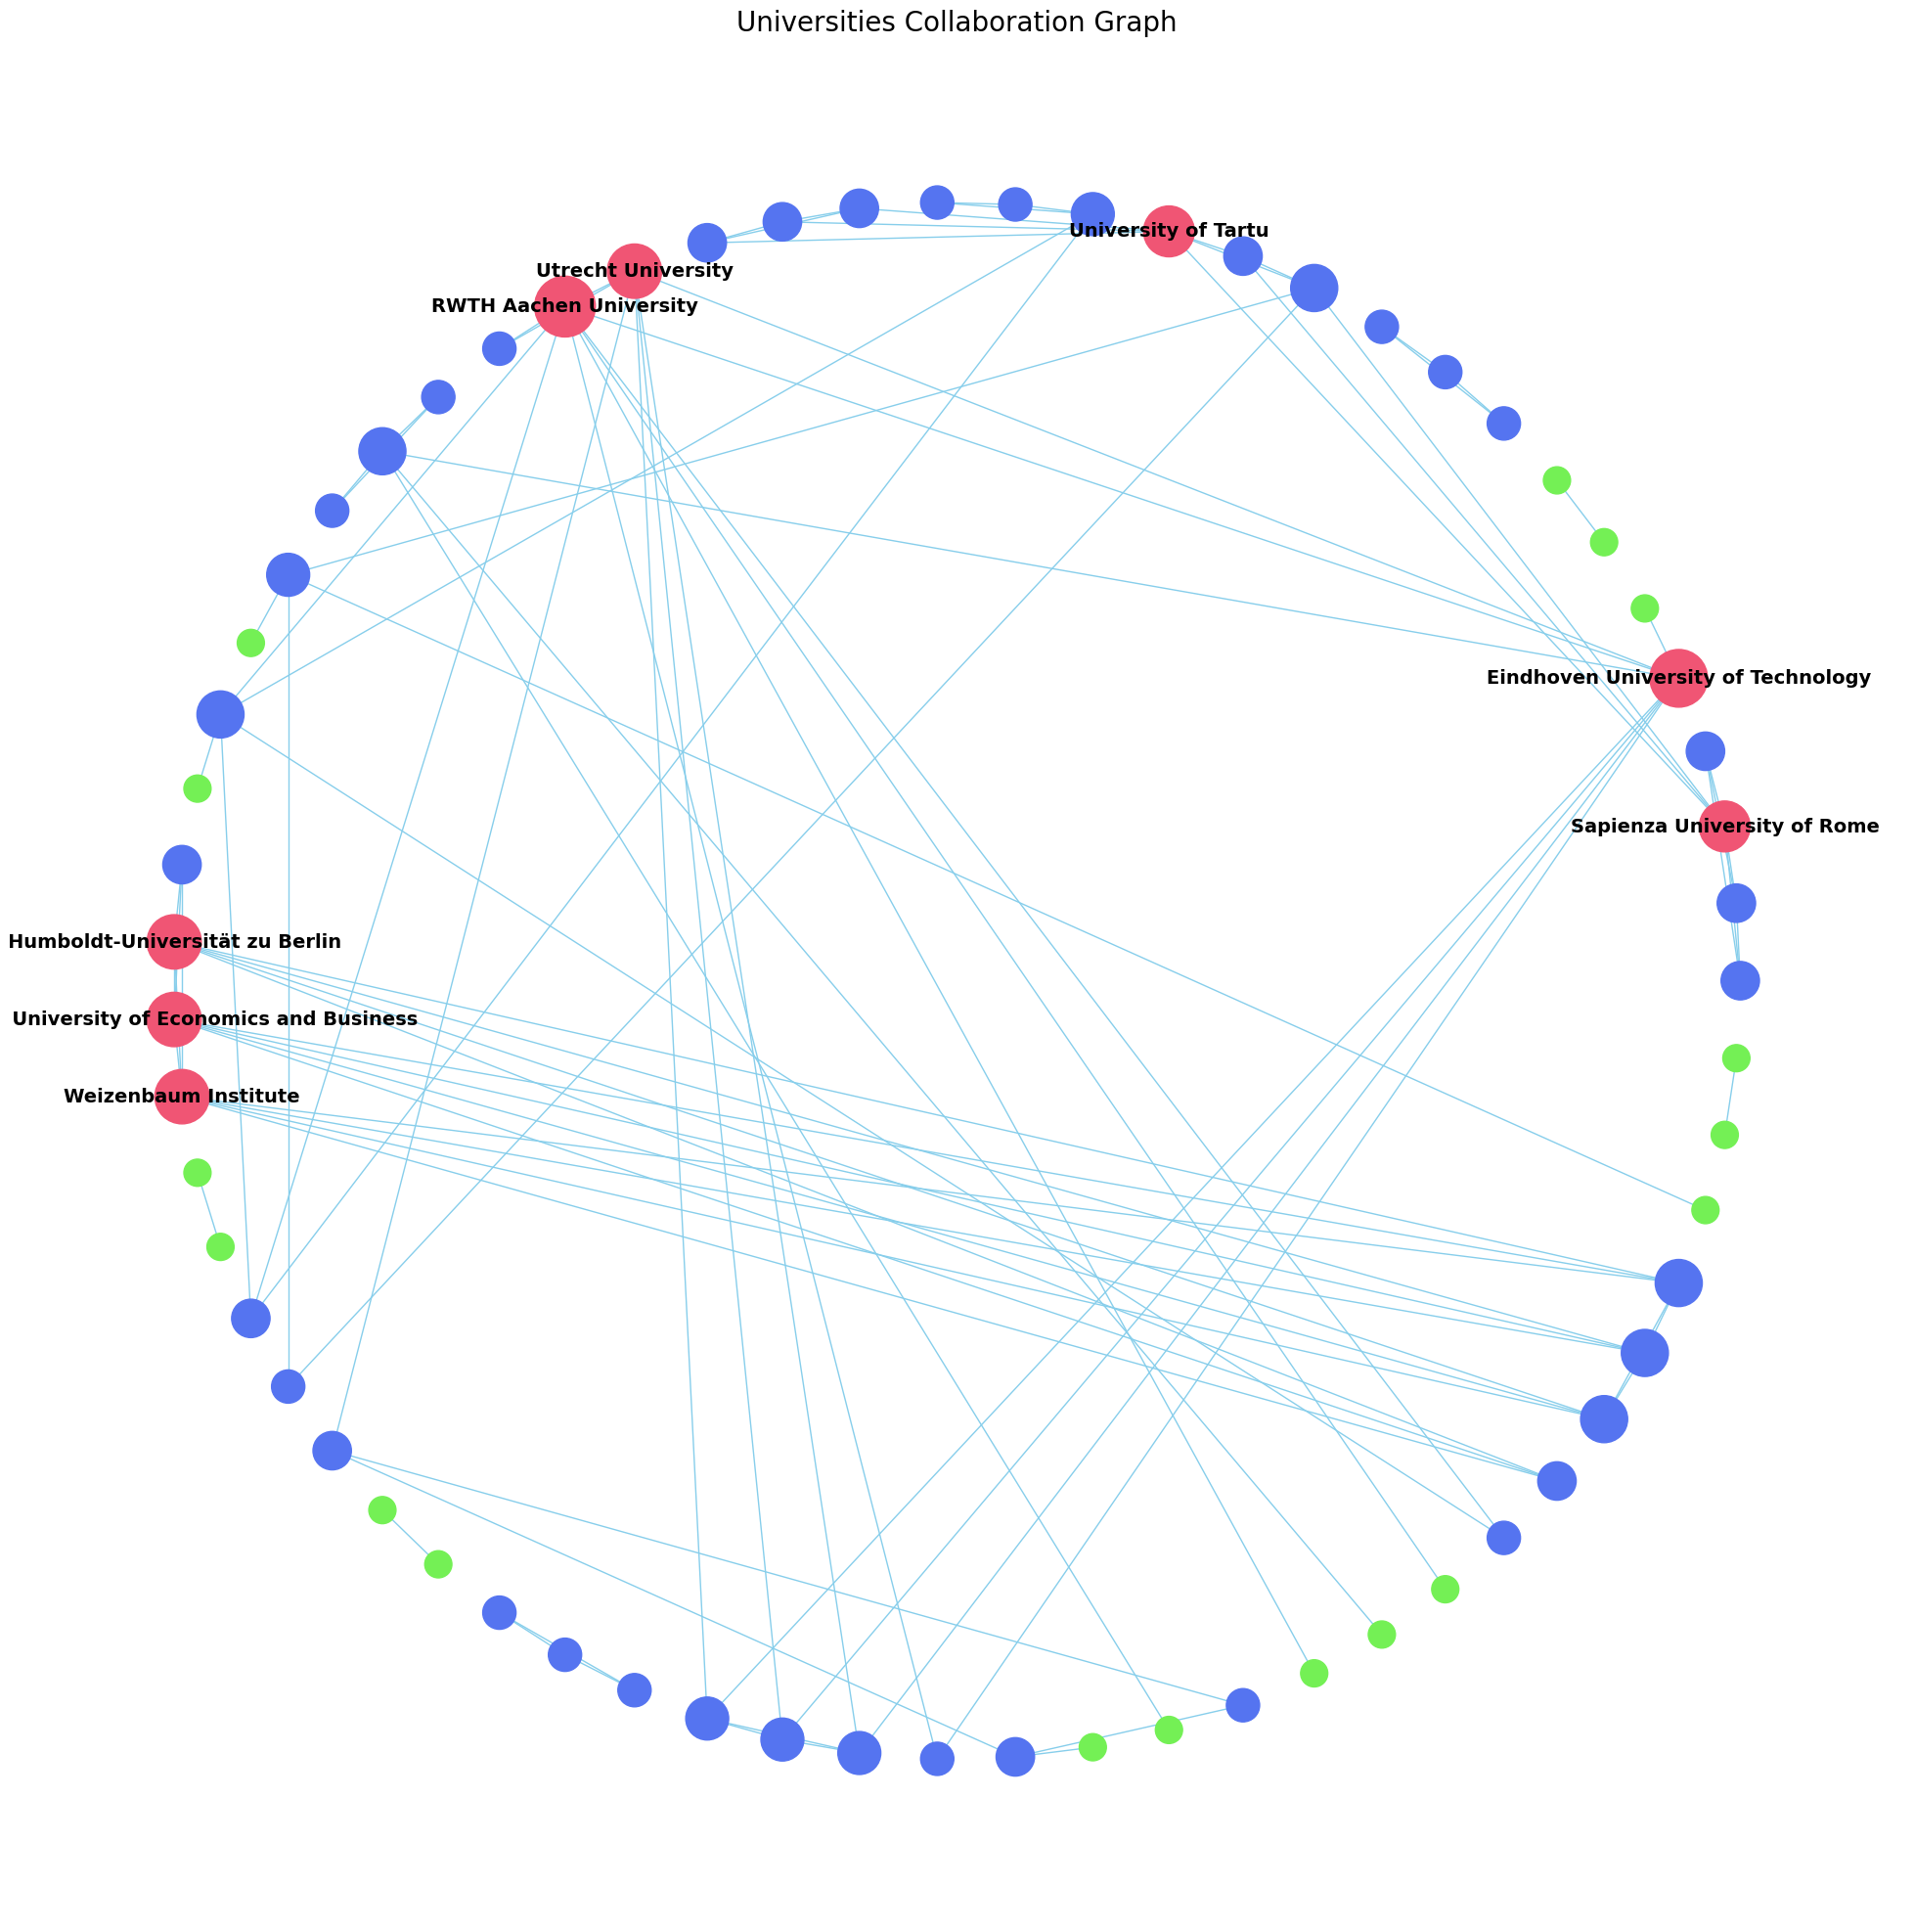

In [153]:
#uni = uni_filtered
#display(uni_filtered)
uni_filtered['Organizations'] = uni_filtered['Organizations'].str.split(', ')
G = nx.Graph()

for index, row in uni_filtered.iterrows():
    universities = row['Organizations']
    if universities is not None:
        # Add edges to the graph for all pairs of universities
        for u1 in universities:
            for u2 in universities:
                if u1 != u2:
                    if G.has_edge(u1, u2):
                        G[u1][u2]['weight'] += 1
                    else:
                        G.add_edge(u1, u2, weight=1)

# Calculate edge colors based on edge weights (collaboration strength)
# edge_colors = []
# for u, v, data in G.edges(data=True):
#     weight = data['weight']
#     if weight >= 5:
#         edge_colors.append('red')
#     else:
#         edge_colors.append('skyblue')

# node sizes 
node_degrees = dict(G.degree())
node_sizes = [200 * (degree + 1) for degree in node_degrees.values()]  # Increase scaling for larger nodes

#  node colors 
node_colors = ['#5574F0' if (degree <= 5 and degree >= 2) else ('#74F055' if degree < 2 else '#F05574') for degree in node_degrees.values()]

plt.figure(figsize=(25, 25))  
pos = nx.circular_layout(G) 
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edge_color='skyblue')
node_labels = {}
for node, degree in node_degrees.items():
    if degree > 5:
        node_labels[node] = node
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=14, font_color='black', font_weight='semibold')
#nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_weight='bold')
plt.title('Universities Collaboration Graph', fontsize=20)
plt.axis('off')
plt.show()


In [154]:
# Group the data by 'Paper Title' and extract distinct countries, where papers were created
countries_hp = data_filtered.groupby('Paper_Title')['Country'].apply(lambda x: ', '.join(set(x.str.split(', ').sum()))).reset_index()

#replace all ; to , - some bag, does not work without it 
countries_hp['Country'] = countries_hp['Country'].str.replace(';', ',')

#remove duplicates
countries_hp['Country'] = countries_hp['Country'].str.split(', ').apply(lambda x: ', '.join(set(x)))


country_counts_hp = countries_hp['Country'].str.split(', ').explode().value_counts().reset_index()
country_counts_hp.columns = ['Country', 'Count']

print('Amount of researchers, who published for the conference among high profile papers:')
display(country_counts_hp.head(10))

def are_countries_same(country_string):
    countries = country_string.split(', ')
    return 'YES' if not all(country == countries[0] for country in countries) else 'NO'


#check if international cooperation was present(e.g. if authors are from different countries)
countries_hp['International'] = countries_hp['Country'].apply(are_countries_same)

# Count the occurrences of 'YES' and 'NO' in the 'International' column
international_hp = countries_hp['International'].value_counts()

percentage_yes = (international_hp.get('YES', 0) / len(countries_hp)) * 100

# Print the result
print(f"International cooperation was present during writing of {percentage_yes:.2f}% of high profile papers")
#papers_countries['International'] = papers_countries['Country_List'].apply(check_international)
display(countries_hp.head(10))

Amount of researchers, who published for the conference among high profile papers:


,Country,Count
0,Germany,28
1,The Netherlands,10
2,Italy,7
3,Austria,6
4,Australia,5
5,Denmark,4
6,Spain,3
7,Belgium,2
8,Switzerland,2
9,Israel,2


International cooperation was present during writing of 50.00% of high profile papers


,Paper_Title,Country,International
0,A Novel Multi-Perspective Trace Clustering Tec...,Belgium,NO
1,A Reference Data Model to Specify Event Logs f...,"Norway, Spain, Italy",YES
2,Action-Evolution Petri Nets: a Framework for M...,The Netherlands,NO
3,Adding the sustainability dimension in process...,"Uruguay, Spain",YES
4,Agent Miner: An Algorithm for Discovering Agen...,"Canada, Australia",YES
5,An SQL-Based Declarative Process Mining Framew...,"Italy, Estonia",YES
6,Analytics Pipeline for Process Mining on Video...,Germany,NO
7,Approximating Multi-Perspective Trace Alignmen...,Italy,NO
8,Benevolent Business Processes – Design Guideli...,Australia,NO
9,Business Process Management Maturity and Proce...,The Netherlands,NO


In [155]:
df = pd.read_excel("coordinates.xlsx", sheet_name='countries')
coordinates = df[df['name'].isin(country_counts_hp['Country'])]
countries_hp = coordinates.merge(country_counts_hp, left_on='name', right_on='Country', how='left')
countries_hp = countries_hp.sort_values(ascending=False, by='Count')
countries_hp = countries_hp.drop('name', axis=1)
display(countries_hp)

countries_hp['text'] = countries_hp['Country'] +': '+ countries_hp['Count'].astype(str) +' researchers'
limits = [(0,1),(2,5),(6,10), (11,15)]
colors = ["royalblue","orange","lightseagreen","crimson","lightgrey"]
cities = []
scale = 10

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = countries_hp[lim[0]:lim[1]+1]
    min_count = df_sub['Count'].min()
    max_count = df_sub['Count'].max()
    label = f'{min_count} - {max_count}'

    fig.add_trace(go.Scattergeo(
        locationmode='ISO-3',
        lon=df_sub['longitude'],
        lat=df_sub['latitude'],
        text=df_sub['text'],
        marker=dict(
            size=df_sub['Count'] * scale,
            color=colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode='area'
        ),
        name=label
    ))


fig.update_layout(
        title_text = 'BPM Conference 2023 - number of authors (main track & forum) in different countries',
        showlegend = True,
        geo = dict(
            showcountries = True,
            resolution = 50,
            projection_type = 'winkel tripel',
            scope = 'world',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

,country,latitude,longitude,Country,Count
6,DE,51.165691,10.451526,Germany,28
12,IT,41.871940,12.567380,Italy,7
0,AT,47.516231,14.550072,Austria,6
1,AU,-25.274398,133.775136,Australia,5
7,DK,56.263920,9.501785,Denmark,4
9,ES,40.463667,-3.749220,Spain,3
2,BE,50.503887,4.469936,Belgium,2
3,CA,56.130366,-106.346771,Canada,2
4,CH,46.818188,8.227512,Switzerland,2
8,EE,58.595272,25.013607,Estonia,2


Keywords and Title Analysis

(Title analysis seems useless as often a word makes sense only as a part of word combination and it these combinations is hard to identify - deeper analysis is required)

Result: The word cloud demonstrating the word frequency in titles of the 'high profile' papers (main track and forum) looks very similar to the word cloud of titles of all papers presented at BPM 2023.

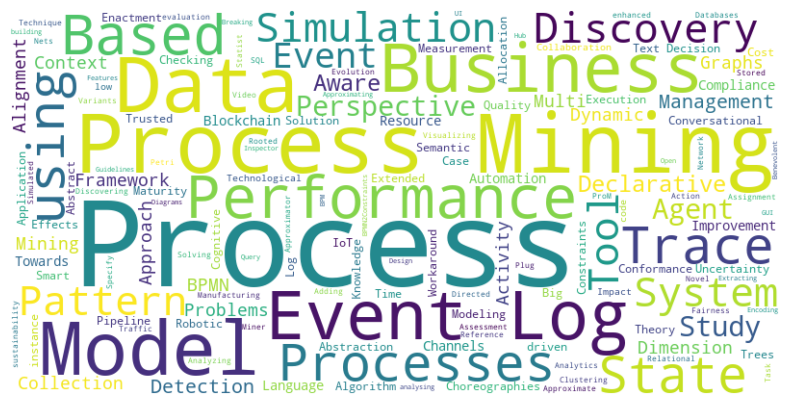

           Word  Count
0       Process     48
1        Mining     16
2         Event     13
3          Data     10
4      Business      8
5          Logs      7
6   Performance      6
7        Models      6
8         Study      4
9   Declarative      4
10   Simulation      4
11         Tool      4
12    Discovery      4
13        Trace      4
14    Detection      4
15        State      4
16     Language      3
17   Compliance      3
18      Towards      3
19    Processes      3


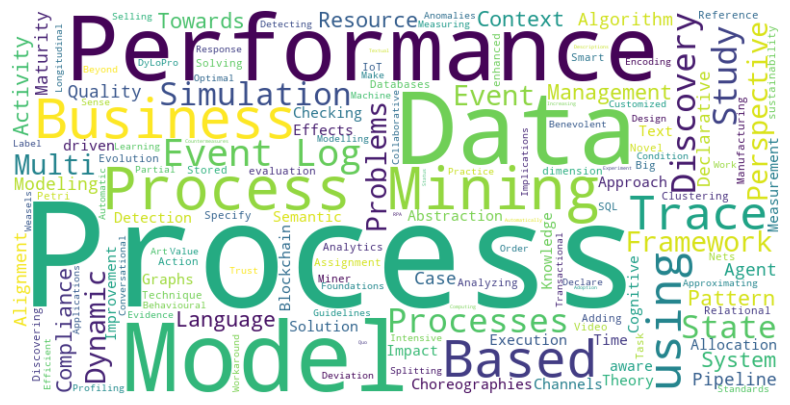

           Word  Count
0       Process     34
1          Data      9
2         Event      8
3      Business      7
4        Mining      7
5   Performance      6
6         Trace      4
7          Logs      4
8         Study      4
9        Models      4
10     Problems      3
11     Language      3
12    Discovery      3
13      Towards      3
14   Simulation      3
15   Compliance      3
16        State      3
17     Resource      3
18     Activity      3
19       Graphs      2


In [156]:
#Title analysis 

#exclude prepositions and articles from word analysis as they are the most common words
common_words_to_exclude = ['a', 'an', 'the', 'in', 'on', 'at', 'to', 'of', 'by', 'with', 'for', 'as', 'and', 'from', 'through', '-', 'using']
titles = data.groupby('Paper_Title').first().reset_index()
titles = titles['Paper_Title']

# Combine all the paper titles into a single string
text_titles = " ".join(titles)

wordcloud_titles = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(text_titles)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis("off")  
plt.show()


top_N_words = 20

# Table with the most common words for titles 
words = text_titles.split()
# leave out prepositions and articles 
filtered_words = [word for word in words if word.lower() not in common_words_to_exclude]
# Count the frequency of each word
word_counts = Counter(filtered_words)
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)
word_counts_df = word_counts_df.reset_index(drop=True)

top_words_df = word_counts_df.head(top_N_words)
print(top_words_df)



#for high profile papers: 
titles_hp = data_filtered.groupby('Paper_Title').first().reset_index()

titles_hp = titles_hp['Paper_Title']
text_titles_hp = " ".join(titles_hp)
wordcloud_titles_hp = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(text_titles_hp)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_titles_hp, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()


top_N_words = 20
 
words_hp = text_titles_hp.split() 
filtered_words_hp = [word for word in words_hp if word.lower() not in common_words_to_exclude]
word_counts_hp = Counter(filtered_words_hp)
word_counts_hp = pd.DataFrame(word_counts_hp.items(), columns=['Word', 'Count'])
word_counts_hp = word_counts_hp.sort_values(by='Count', ascending=False)
word_counts_hp = word_counts_hp.reset_index(drop=True)

top_words_hp = word_counts_hp.head(top_N_words)
print(top_words_hp)



In [157]:
#main track keywords analysis

with open('BPM2023MainTrack.pdf', 'rb') as pdf_file:
    pdf_reader = PyPDF2.PdfReader(pdf_file)

    keywords = []   
    in_keywords_section = False

    # Iterate through each page in the PDF
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text = page.extract_text()
        
        #Keywords are located between "Keywords:" and "1 Introduction", however there is an exception: 
        #there in no introduction section in one of the papers, instead there is "1 Beyond Transactional Value" section name
        keyword_pattern = re.compile(r'Keywords: (.*?)(1 Introduction|1 Beyond Transactional Value)', re.DOTALL | re.IGNORECASE)

        keyword_match = re.search(keyword_pattern, text)

        if keyword_match:
            keywords_text = keyword_match.group(1).strip()
            keywords.extend(keywords_text.split('  '))  #   is the delimiter

            

keywords = pd.DataFrame({'Keywords': keywords})

keywords['Keywords'] = keywords['Keywords'].astype(str)

keywords = keywords['Keywords'].str.split('·', expand=True).stack().reset_index(level=1, drop=True).to_frame('Keyword')
keywords.reset_index(drop=True, inplace=True)
keywords['Keyword'] = keywords['Keyword'].astype(str)
keywords['Keyword'] = keywords['Keyword'].str.replace('\n', '')
keywords = keywords.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
keywords['Keyword'] = keywords['Keyword'].str.lower()

keywords_mainTrack = keywords



In [158]:
#Forum keywords analysis 
with open('BPM2023Forum.pdf', 'rb') as pdf_file:
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    keywords = []
               
    in_keywords_section = False

    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text = page.extract_text()

        keyword_pattern = re.compile(r'Keywords: (.*?)1 Introduction', re.DOTALL | re.IGNORECASE)

        keyword_match = re.search(keyword_pattern, text)

        if keyword_match:
            keywords_text = keyword_match.group(1).strip()
            keywords.extend(keywords_text.split('  '))  #    is the delimiter

              

keywords = pd.DataFrame({'Keywords': keywords})


keywords['Keywords'] = keywords['Keywords'].astype(str)

keywords = keywords['Keywords'].str.split('·', expand=True).stack().reset_index(level=1, drop=True).to_frame('Keyword')
keywords.reset_index(drop=True, inplace=True)
keywords['Keyword'] = keywords['Keyword'].astype(str)
keywords['Keyword'] = keywords['Keyword'].str.replace('\n', ' ')
keywords = keywords.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
keywords['Keyword'] = keywords['Keyword'].str.lower()
keywords_forum = keywords






Unique Keywords:


array(['runtime compliance checking', 'commitments', 'blockchain',
       'smart contracts', 'choreography diagrams',
       'decentralized process execution',
       'blockchain-based process execution',
       'inter-organizational process execution',
       'big data pipeline discovery (bdpd)', 'big data pipeline',
       'reference data model', 'process mining', 'event log', 'dark data',
       'xes', 'declarative process modelling', 'collaborative processes',
       'model analysis', 'reactive synthesis', 'ltlon ﬁnite traces',
       'choreographies', 'declarative models',
       'multi-perspective process modelling', 'process choreographies',
       'interaction petri nets', 'data ﬂow',
       'natural language processing', 'large language models',
       'generative pre-trained transformer', 'deep learning',
       'research challenges', 'predictive process monitoring',
       'unseen behavior', 'context information', 'compliance constraints',
       'batch', 'workload', 'throug


Keyword Frequencies:


,Keyword,Frequency
0,process mining,18
1,conformance checking,4
2,process discovery,4
3,event logs,4
4,process performance,3
...,...,...
164,resource experience,1
165,bpmn,1
166,low-code,1
167,data perspective,1


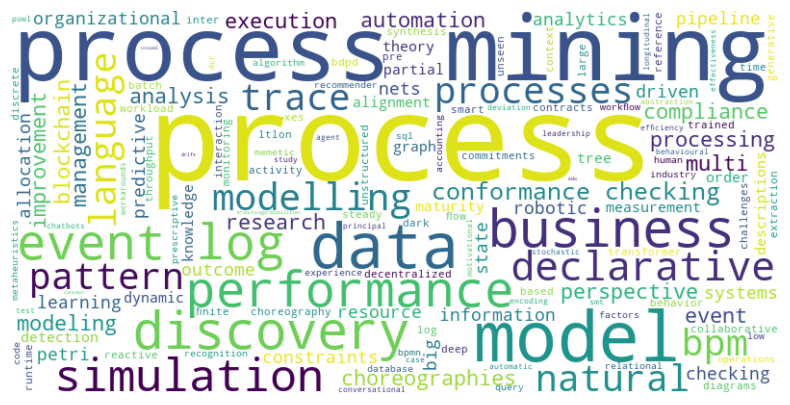

In [159]:
# add keywords from Forum document and MainTrack document together
keywords_hp = pd.concat([keywords_forum, keywords_mainTrack], axis=0)
keywords_hp.reset_index(drop=True, inplace=True)

unique_keywords = keywords_hp['Keyword'].unique()
keyword_frequencies = keywords_hp['Keyword'].value_counts().reset_index()
keyword_frequencies.columns = ['Keyword', 'Frequency']

print("Unique Keywords:")
display(unique_keywords)

print("\nKeyword Frequencies:")
display(keyword_frequencies)



# visualuzation
keywords_c = keywords_hp['Keyword']
text_keywords = " ".join(keywords_c)
wordcloud_titles_hp = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(text_keywords)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_titles_hp, interpolation='bilinear')
plt.axis("off")  
plt.show()

In [160]:
#demo, dissertation, PhD keywords - are added to the excel sheet manually
keywords_rest = data.groupby('Paper_Title')['Keywords'].first().reset_index()

keywords = pd.DataFrame({'Keywords': keywords_rest['Keywords']})
keywords.dropna(inplace=True)


keywords = keywords['Keywords'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('Keyword')
keywords.reset_index(drop=True, inplace=True)

keywords = keywords.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
keywords['Keyword'] = keywords['Keyword'].str.replace('\n', '')
keywords['Keyword'] = keywords['Keyword'].str.replace('\t', ' ')
keywords['Keyword'] = keywords['Keyword'].str.lower()

keywords_r = keywords

Unique Keywords:
236

Keyword Frequencies:


,Keyword,Frequency
0,process mining,32
1,process discovery,7
2,robotic process automation,5
3,conformance checking,5
4,business process management,5
5,event logs,4
6,process performance,3
7,process improvement,3
8,blockchain,3
9,performance analysis,2


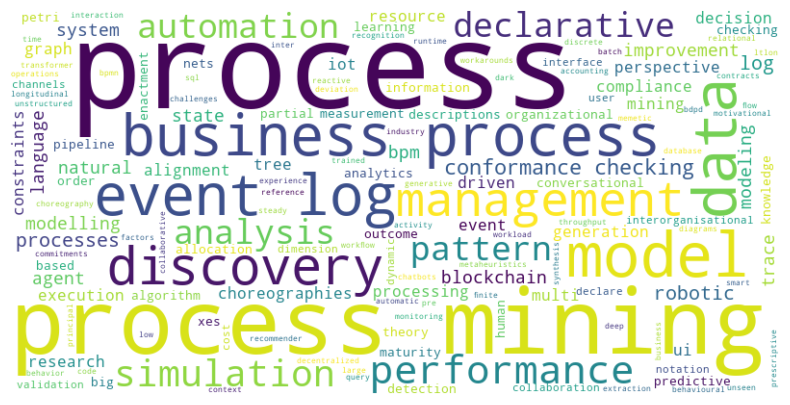

In [161]:
#all keywords together
keywords_all = pd.concat([keywords_hp, keywords_r], axis=0)
keywords_all.to_excel('test.xlsx', index=False)

# Reset the index of the combined DataFrame
keywords_all.reset_index(drop=True, inplace=True)


# Print or use the DataFrame as needed
unique_keywords = keywords_all['Keyword'].unique()

# Count the frequency of each unique keyword
keyword_frequencies = keywords_all['Keyword'].value_counts().reset_index()
keyword_frequencies.columns = ['Keyword', 'Frequency']

# Print the unique keywords and their frequencies
print("Unique Keywords:")
print(len(unique_keywords))

print("\nKeyword Frequencies:")
display(keyword_frequencies.head(10))



# Extract the "Paper_Title" column
keywords_c = keywords_all['Keyword']

# Combine all the paper titles into a single string
text_keywords = " ".join(keywords_c)

# Create a WordCloud object with some customization
wordcloud_titles_hp = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(text_keywords)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_titles_hp, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

In [167]:
country_counts_df = pd.DataFrame(country_counts)
display(country_counts_df)

,Country,Count
0,Germany,40
1,The Netherlands,14
2,Italy,12
3,Austria,6
4,Australia,6
5,Spain,6
6,Denmark,5
7,Israel,4
8,Chile,3
9,Belgium,3


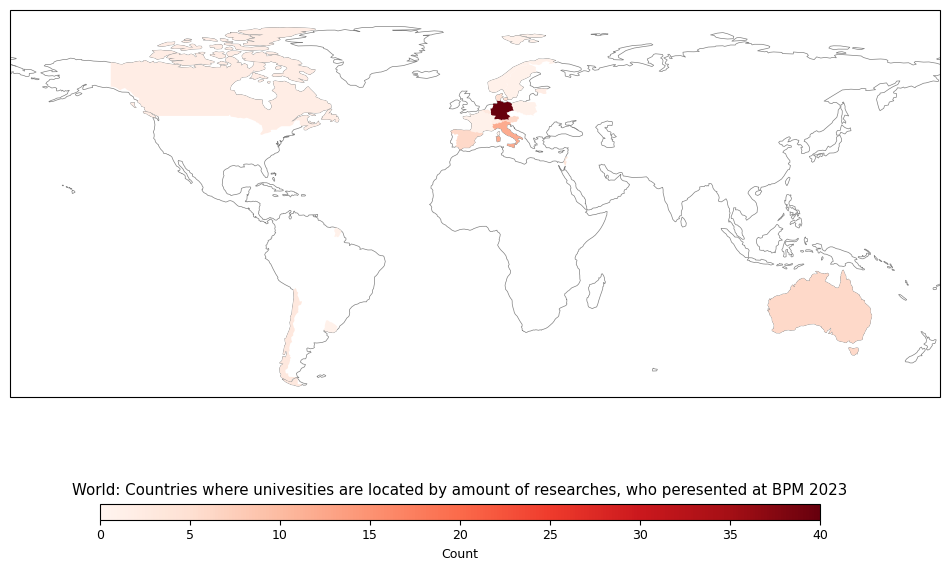

In [168]:
country_counts = dict(zip(country_counts_df['Country'], country_counts_df['Count']))
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='gray')  # Reduced linewidth and gray color
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

cmap = plt.cm.Reds 
norm = plt.Normalize(0, max(country_counts.values()))  # Normalize colors based on data range

# Load Natural Earth countries geometries (requires 'naturalearth_lowres' shapefile)
countries = gpd.read_file('World/ne_110m_admin_0_countries.shp')


for index, row in countries.iterrows():
    country_name = row['ADMIN']
    if country_name in country_counts:
        count = country_counts[country_name]
        color = cmap(norm(count))
        ax.add_geometries([row['geometry']], crs=ccrs.PlateCarree(), facecolor=color, edgecolor='none')  # No border

cax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Count')

plt.title('World: Countries where univesities are located by amount of researches, who peresented at BPM 2023')
plt.show()


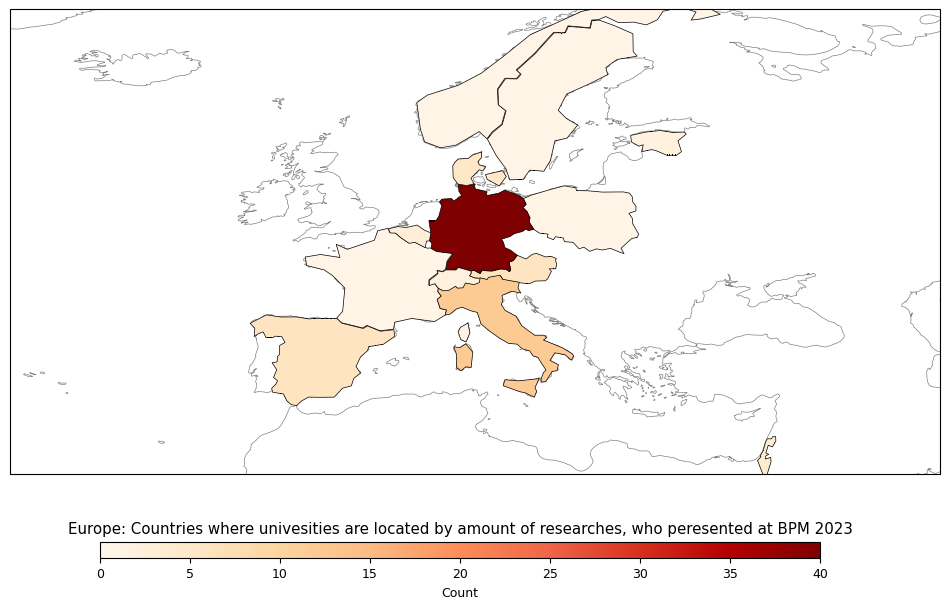

In [169]:
country_counts = dict(zip(country_counts_df['Country'], country_counts_df['Count']))
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='gray')  # Reduced linewidth and gray color


ax.set_extent([-30, 50, 30, 70], crs=ccrs.PlateCarree())  # Adjusted extent for Europe


cmap = plt.get_cmap('OrRd')
norm = plt.Normalize(0, max(country_counts.values()))  # Normalize colors based on data range

countries = gpd.read_file('World/ne_110m_admin_0_countries.shp')


def is_in_europe(lon, lat):
    return -30 <= lon <= 50 and 30 <= lat <= 70

# Plot each European country with precise borders
for index, row in countries.iterrows():
    country_name = row['ADMIN']
    if country_name in country_counts:
        count = country_counts[country_name]
        color = cmap(norm(count))
        geometry = row['geometry']
        
        # Check if the centroid of the country's geometry is within the Europe bounding box
        centroid = geometry.centroid
        if is_in_europe(centroid.x, centroid.y):
            ax.add_geometries([geometry], crs=ccrs.PlateCarree(), facecolor=color, edgecolor='black', linewidth=0.5)

cax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [left, bottom, width, height]

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Count')
plt.title('Europe: Countries where univesities are located by amount of researches, who peresented at BPM 2023')
plt.show()

